# Demo: Working with multi-dimensional image data
---
This notebook explores a few uses of multi-dimensional datasets made avaialable through ArcGIS Online. Here, we explore the Sea Surface Temperature (SST) dataset [link](https://www.arcgis.com/home/item.html?id=100a26c4d15445ffadab0d04e536b9c1). This dataset contains daily SST values from 1985 to the present at a 0.05° (~5km) resolution across all ocean surfaces.  

The exact procedures and operations covered include:

* Setting up the coding session for accessing and querying multi-dimensional data
* Reading the multi-dimensional into the coding session
* Exploring properties of the dataset
* Extracting values at specific locations and times
* Creating a time series dataset for one or several points

What's not covered here yet (as our Organization AGOL subscription does not cover) includes: 
* Creating mosaic layers from the multi-dimensional data, i.e., aggregating data across time slices
---
Fall 2024  
John.Fay@duke.edu

---


## 1. Setting up the coding environment
ESRI's ArcGIS API for Python provides the functionality for working with these multi-dimensional rasters. We need to import a few sub-modules, including the `GIS` sub-module which we use to authenticate to Duke's AGOL Organizational account. 

In [1]:
#Import packages
from arcgis import GIS
from arcgis.raster import ImageryLayer, Raster
from arcgis.raster.functions import multidimensional_filter
from arcgis.mapping import MapServiceLayer
from arcgis.geometry import Point, Polygon, filters, Geometry

from datetime import datetime, timedelta

#Connect to GIS via ArcGIS Pro
gis = GIS("home")

## 2. Accessing and exploring  the SST raster dataset

### 2.1 Fetching the SST Item and its one layer
The item page for the SST data is: https://www.arcgis.com/home/item.html?id=100a26c4d15445ffadab0d04e536b9c1. 

We'll begin by fetching this item into our computing environment and then fetching the layer associated with this item.

<Item title:"Sea Surface Temperature (SST)" type:Imagery Layer owner:esri>
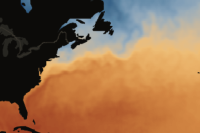

In [3]:
#Fetch the item via its ItemID
sst_item = gis.content.get('100a26c4d15445ffadab0d04e536b9c1')
sst_item

In [6]:
#List the layers in the SST item
sst_layers = sst_item.layers
sst_layers

[<ImageryLayer url:"https://oceans5.arcgis.com/arcgis/rest/services/SST/ImageServer">]

In [7]:
#Fetch the one (and only) layer in the SST item and reveal its type
sst_layer = sst_layers[0]
type(sst_layer)

arcgis.raster._layer.ImageryLayer

→ Note that the layer we have is an **ImageryLayer**. Info on this ImageryLayer is [here](https://developers.arcgis.com/python-2-3/api-reference/arcgis.raster.toc.html#imagerylayer).


### 2.3 Exploring properties of the imagery layer
Let's move on to examining properties we'll need to work with the dataset. `sst_layer` is an ImageryLayer object and we can examine documentation on that type of object [here](https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.toc.html#imagerylayer). 

Specifically, we'll confirm that our ImageryLayer is multi-dimensional, and then extract its multi-dimensional properties. 

In [8]:
#Confirm the SST layer has multidimensions
sst_layer.properties.hasMultidimensions

True

Multi-dimensional data are comprised of *variables*, *dimensions*, and *attributes*. 
* **Variables** represent the actual data values or measurements stored in the multidimensional raster. 
* **Dimensions** define the structure and organization of the data (how we access specific bits of data).
* **Attributes** describe the structure of the variable within each dimension

To reveal the dimensions in our ImageryLayer, it's easier to first convert it to a [**Raster object**](https://developers.arcgis.com/python-2-3/api-reference/arcgis.raster.toc.html#raster), which is done simply by reading the ImageryLayer's URL in as a Raster. 

In [14]:
#Convert the SST layer to a multidimensional raster object
sst_raster_md = Raster(
    path=sst_layer.url,
    is_multidimensional=True)

This Raster object has functions to reveal the variables contained, and the dimensions of each variable. 

In [15]:
#Reveal the variables in the SST raster
sst_raster_md.variable_names

['alert', 'sst', 'ssta']

We see that the dataset <u>has three variables</u>: 
* `alert` - Coral bleaching heat stress alert level
* `sst` - Sea Surface Temperature
* `ssta` - Sea Surface Temperature Anomalies

The source for what these variables represent is here:  
<https://coralreefwatch.noaa.gov/product/5km/index_5km_baa-max-7d.php>

The one we want is the second: `sst`. Now we can examine the <u>dimensions</u> associated with that variable. 

In [16]:
#Reveal the dimensions in the SST raster's 'sst' variable
sst_raster_md.get_dimension_names('sst')

['StdTime']

Just the one dimension: `StdTime`, which is the *time* dimension. 

Now, let's look at the <u>attributes</u> and some <u>values</u> in this time dimension of the sst variable by applying the raster's `get_dimensions_attributes()` function. 

In [17]:
#Get attributes for the 'StdTime' dimension in the SST raster
sst_raster_md.get_dimension_attributes(
    variable_name='sst', 
    dimension_name='StdTime'
)

{'Interval': 1,
 'IntervalUnit': 'Days',
 'HasRegularIntervals': True,
 'HasRanges': False,
 'Minimum': '1985-01-01T12:00:00+00:00',
 'Maximum': '2024-11-17T12:00:00+00:00',
 'Unit': '',
 'Description': ''}

Interpreting the result, we see this dataset has an sst layer for every day (Interval/IntervalUnit) spanning from Jan 1, 1985 to quite recently!

Next,we'll have a peek at some of the values in this `StdTime` dimension of the `sst` variable. 

In [19]:
#Take a peek at the first 5 time values in the SST raster
time_values = sst_raster_md.get_dimension_values(
    variable_name='sst', 
    dimension_name='StdTime'
)
print(len(time_values))
time_values[0:5]

14564


['1985-01-01T12:00:00+00:00',
 '1985-01-02T12:00:00+00:00',
 '1985-01-03T12:00:00+00:00',
 '1985-01-04T12:00:00+00:00',
 '1985-01-05T12:00:00+00:00']

##### Recapping what we just learned: 
* The multi-dimension SST ImageryLayer has quite a lot of data! 
* The layer contains three separate variables: *alert levels*, *sst*, and *sst anomalies*.
* The `sst` variable (as well as the other two) have measurements recorded across a time dimension ("`StdTime`")
* This time dimension contains daily SST measurements from 1985 to the present, over 14,000 records (for ever 5 square km of ocean surface)

##### And moving forward, we want to tap into this massive dataset in three ways: 
* Extract a single SST value at a define location and time
* Extract a set of SST values falling within a specific geometry and summarize the values
* Extract a time series of SST values at a define location or set of locations

---

## 3. Extracting data

### 3.1 Extract sea surface temperature at a given location for a given time
The [`identify()`](https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.toc.html#arcgis.raster.ImageryLayer.identify) function of an ImageryLayer allows us to extract values from a multidimensional image for a provided a spatial and temporal extent (e.g. a point and a start & end times). To do this, we first need create a **Point object** and specifiy the start and end times as a **datetime** object, so that we can pass these as input parameters into the `identify()` function. 



#### Creating the Point object
In the first code cell, we import the `Point` class from the `arcgis.geometry` submodule. Documentation on this class is [here](https://developers.arcgis.com/python/latest/api-reference/arcgis.geometry.html#point), with the code involved in creating a point (and other geometries) found in [this tutorial](https://developers.arcgis.com/python/latest/guide/tutorials/add-a-point-line-and-polygon/).

Below, we'll create some geometries to use in our spatial queries: first, a point from lat and lng variables (specifying the spatial reference as well) and then a polygon, created by offsetting our point to create the corners used to define the polygon. 

In [29]:
#Start by setting the coordinate of our point
lat = 35.402234
lng = -74.4840627

#Create a point, using the lat and lng coordinates and the spatial reference of WGS84
the_point = Point({
    "x" : lng, 
    "y" : lat, 
    "spatialReference" : {"wkid" : 4326}
    })

#Show the type of our point
type(the_point)

arcgis.geometry._types.Point

In [138]:
#Create an area polygon from the point

#Set the corners as offsets from the lat/lng values
offset = 0.25
xmin = lng - offset
xmax = lng + offset
ymin = lat - offset 
ymax = lat + offset

#Construct the polygon
the_polygon = Polygon({
    "rings": [[
         [xmin,ymin],
         [xmin,ymax],
         [xmax,ymax],
         [xmax,ymin],
         [xmin,ymin]
        ]],
    "spatialReference": {"wkid": 4326}
})

#Set the corners as offsets from the lat/lng values
offset = 0.45
xmin = lng - offset
xmax = lng + offset
ymin = lat - offset 
ymax = lat + offset

#Construct the polygon
the_polygon2 = Polygon({
    "rings": [[
         [xmin,ymin],
         [xmin,ymax],
         [xmax,ymax],
         [xmax,ymin],
         [xmin,ymin]
        ]],
    "spatialReference": {"wkid": 4326}
})

In [33]:
sst_layer.url

'https://oceans5.arcgis.com/arcgis/rest/services/SST/ImageServer'

In [38]:
#OPTIONAL: View the point on a map
map1 = gis.map(
    location=tuple(the_point.coordinates()[::-1]), #Switch the order of the coordinates
    zoomlevel=8
)

map1.add_layer(sst_layer) #Add the sst layer
map1.draw(the_polygon)    #Add the polygon created above
map1.draw(the_point)      #Add the point created above

#Draw the map
#map1

#### Creating the time slice
We use Python's `datetime` class, from of the `datetime` module, to create the start and end times for our `identify()` tool. We can either explicitly set both times, or set the start time and specify the end time as a period of time ("timedelta") after the start time. 

Recalling that our SST data records sea surface temperature daily, we'll set the start as June 21, 2010 and the end as the following day - June 22, 2010.

In [57]:
#Create datetime objects for the start and end dates
start_date = datetime(2010, 6, 21)
end_date = datetime(2020, 6, 22)

#or we can set the end date as the start date plus a "timedelta" of 1 day
end_date = start_date + timedelta(days=1)

#Show the dates
print(start_date, end_date)

2010-06-21 00:00:00 2010-06-22 00:00:00


#### Running the `identify()` tool
We now have the ingredients to run the `identify()` tool: the **geometry** (our point), the **time_extent** (our start & end times), and of course our SST imagery layer. We also need to specify that our imagery layer is multidimensional. 

In [58]:
#Identify the SST values at the point for the specified time extent
sst_result = sst_layer.identify(
    geometry=the_point,
    time_extent=[start_date,end_date],
    process_as_multidimensional=True,
)

#Reveal the result
sst_result

{'objectId': 0,
 'name': 'Pixel',
 'value': '27.85',
 'location': {'x': -74.4840627,
  'y': 35.402234,
  'spatialReference': {'wkid': 4326, 'latestWkid': 4326}},
 'properties': {'Attributes': [{'Variable': 'sst',
    'StdTime': 1719230400000,
    'StdTime_Max': 1719230400000}]},
 'catalogItems': None,
 'catalogItemVisibilities': []}

#### Interpreting the result
We see that the result is a dictionary. This dictionary includes values for each of the three variables, among some other information that may or may not be useful to us. Anyway, we can use our Python dictionary skills to pull out the value we want: the second item in the list associated with the `value` key (converted to a floating point number).

In [60]:
#Fetch the SST value at the point
the_sst = float(sst_result['value'].split('; ')[0])

#Report the SST value
print(f'At the point ({lat}, {lng}) on {start_date} the SST was {the_sst} degrees Celsius')

At the point (35.402234, -74.4840627) on 2010-06-21 00:00:00 the SST was 27.85 degrees Celsius


### Extracting values within an area
https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.functions.html#multidimensional-filter

In [126]:
#Select one variable from the raster (sst) and one time slice
sst_layer_1d = multidimensional_filter(
    raster = sst_raster_md,
    variables=['sst'],
    dimension_values=[{
        'dimension': 'StdTime',
        'value':start_date#'473428800000'
    }],
)

In [192]:
sst_layer_2d = multidimensional_filter(
    raster = sst_raster_md,
    variables=['sst'],
    dimension_definition='BY_RANGES',
    dimension='StdTime',
    dimension_ranges=[
        {'dimension':'StdTime', 
         'minValue':'1985-10-15T12:00:00+00:00', 
         'maxValue':'1985-10-16T12:00:00+00:00'}
    ]
)

In [193]:
sst_layer_2d.multidimensional_info['multidimensionalInfo']['variables'][0]['dimensions']

[{'name': 'StdTime',
  'field': 'StdTime',
  'description': '',
  'unit': '',
  'extent': ['1985-10-15T12:00:00+00:00', '1985-10-16T12:00:00+00:00'],
  'hasRanges': False,
  'values': ['1985-10-15T12:00:00+00:00', '1985-10-16T12:00:00+00:00']}]

In [194]:
extracted_values = sst_layer_1d.summarize(geometry=the_polygon)
extracted_values

[{'min': 19.079999923706055,
  'max': 20.420000076293945,
  'mean': 19.773400516510016,
  'standardDeviation': 0.39474369484690214,
  'sum': 1977.3400516510017,
  'median': 19.799921574312098,
  'mode': 19.799921574312098,
  'skipX': 1,
  'skipY': 1,
  'count': 100,
  'covariances': '0.000000'}]

In [195]:
extracted_values = sst_layer_2d.summarize(geometry=the_polygon)
extracted_values

[{'min': 23.219999313354492,
  'max': 25.5,
  'mean': 24.785100059509283,
  'standardDeviation': 0.5716196899350549,
  'sum': 2478.510005950928,
  'median': 24.891999816894533,
  'skipX': 1,
  'skipY': 1,
  'count': 100,
  'covariances': '0.000000'}]

### 3.2 Create a time series plot
With knowledge of the structure of our dataset, we can run some other data extraction/visualization tools as well. Here we look at the `temporal_profile()` function that generates a nice line plot of our variable at a location, or multiple locations, as well as a trendline.

In [ ]:
sst_layer.temporal_profile(
    points=[the_point], 
    time_field='StdTime',
    variables=['sst'],
    time_extent=[datetime(2010,1,1),datetime(2015,1,2)],
    trend_type='linear'
)

## Temporal Averaging
If we had access to an AGOL server capable of raster analysis, we could aggregate values over time. The code would look like this.

In [ ]:
#Import the 'aggregate_multidimensional_raster' function
from arcgis.raster.analytics import aggregate_multidimensional_raster

#Aggregate the SST raster to monthly intervals
agg_raster = aggregate_multidimensional_raster(
    input_multidimensional_raster=sst_raster, 
    dimension='StdTime', 
    variables=['sst'], 
    aggregation_method='MEAN', 
    aggregation_definition='ALL', 
    interval_keyword='MONTHLY', 
    gis=gis
)